In [2]:
import os
import importlib
import time

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage
from skimage import transform as skimg_transform
#from skimage import io as img_io
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils, models
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import load_data
import model
import warnings

In [3]:
plt.style.use('Solarize_Light2')
warnings.filterwarnings('ignore')
%matplotlib inline
importlib.reload(load_data)
importlib.reload(model)

<module 'model' from '/home/uldo/work/kaggle/competitions/Humpback_Whale_Identification/code/model.py'>

In [4]:
#BATCH_SIZE = 100
#BATCH_SIZE = 32
#BATCH_SIZE = 200
#BATCH_SIZE = 128
#BATCH_SIZE = 64
BATCH_SIZE = 32
#IMAGE_W = 100
IMAGE_W = 256
#IMAGE_H = 100
IMAGE_H = 256

In [5]:
'''
class HWI_ConvNeuralNet(nn.Module):
    
    def __init__(self):
        super(HWI_ConvNeuralNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 6, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 12, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop_out = nn.Dropout()
        self.out1 = nn.Linear(int(12 * IMAGE_W/4 * IMAGE_H/4), 900)
        self.out2 = nn.Linear(900, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.drop_out(x)
        output = self.out1(x)
        output = self.out2(output)
        #return output, x
        return output[:, 0]
        #return F.log_softmax(output, dim=1)
'''

'\nclass HWI_ConvNeuralNet(nn.Module):\n    \n    def __init__(self):\n        super(HWI_ConvNeuralNet, self).__init__()\n        self.conv1 = nn.Sequential(\n            nn.Conv2d(3, 6, 5, 1, 2),\n            nn.ReLU(),\n            nn.MaxPool2d(kernel_size=2)\n        )\n        self.conv2 = nn.Sequential(\n            nn.Conv2d(6, 12, 5, 1, 2),\n            nn.ReLU(),\n            nn.MaxPool2d(kernel_size=2)\n        )\n        self.drop_out = nn.Dropout()\n        self.out1 = nn.Linear(int(12 * IMAGE_W/4 * IMAGE_H/4), 900)\n        self.out2 = nn.Linear(900, 1)\n        \n    def forward(self, x):\n        x = self.conv1(x)\n        x = self.conv2(x)\n        x = x.view(x.size(0), -1)\n        output = self.drop_out(x)\n        output = self.out1(x)\n        output = self.out2(output)\n        #return output, x\n        return output[:, 0]\n        #return F.log_softmax(output, dim=1)\n'

In [6]:
class HWI_ConvNeuralNet(nn.Module):
    
    def __init__(self):
        super(HWI_ConvNeuralNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 7, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)        
        self.pool2 = nn.AvgPool2d(3, 3)
        
        self.fc1 = nn.Linear(64 * 4 * 4 * 16, 1024)
        #self.fc1 = nn.Linear(64, 1024)
        #self.fc2 = nn.Linear(1024, 5004)
        self.fc2 = nn.Linear(1024, 1)
        
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print("forward, input x.size(): ", x.size())
        x = self.pool(F.relu(self.conv2_bn(self.conv1(x))))
        #print("forward, x.size() after self.pool(F.relu(self.conv2_bn(self.conv1(x)))): ", x.size())
        x = self.pool2(F.relu(self.conv2(x)))
        #print("forward, x.size() after self.pool2(F.relu(self.conv2(x))): ", x.size())
        x = x.view(-1, 64 * 4 * 4 * 16)
        #print("forward, x.size() after x.view(-1, 64 * 4 * 4 * 16): ", x.size())
        x = F.relu(self.fc1(x))
        #print("forward, x.size() after F.relu(self.fc1(x)): ", x.size())
        x = self.dropout(x)
        #print("forward, x.size() after self.dropout(x): ", x.size())
        x = self.fc2(x)
        #print("forward, x.size() after self.fc2(x): ", x.size())
        #x = self.fc3(x)
        x = self.sigmoid(x)
        #print("forward, x.size() after self.sigmoid(x): ", x.size())
        return x       

In [7]:
class HWI_ConvNeuralNet(nn.Module):
    
    def __init__(self):
        super(HWI_ConvNeuralNet, self).__init__()
        '''
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 6, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 12, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop_out = nn.Dropout()
        self.out1 = nn.Linear(int(12 * IMAGE_W/4 * IMAGE_H/4), 900)
        self.out2 = nn.Linear(900, 1)
        '''
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, stride=2, padding=4)
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        #self.fc1 = nn.Linear(int(IMAGE_H * IMAGE_W 131072 x 16), 1024)
        #self.fc1 = nn.Linear(524288 * 64, 1024)
        self.fc1 = nn.Linear(32768 * 16, 1024)
        self.fc2 = nn.Linear(1024, 32)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        
        #forward, input x.size():  torch.Size([64, 3, 256, 256])
        #forward, after F.relu(self.conv1(x)) x.size():  torch.Size([64, 32, 128, 128])
        #forward, after self.pool(x) x.size():  torch.Size([64, 32, 64, 64])
        #forward, after F.relu(self.conv2(x)) x.size():  torch.Size([64, 64, 32, 32])
        #forward, after self.pool(x) x.size():  torch.Size([64, 64, 16, 16])
        #forward, after x.view(-1, 65536 * 16) x.size():  torch.Size([1, 1048576])
        #forward, after F.relu(self.fc1(x)) x.size():  torch.Size([1, 1024])
        #forward, after self.dropout x.size():  torch.Size([1, 1024])
        #forward, after self.fc2 x.size():  torch.Size([1, 1])
        #forward, after self.sigmoid(x) x.size():  torch.Size([1, 1])
        
    def forward(self, x):
        '''
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.drop_out(x)
        output = self.out1(x)
        output = self.out2(output)
        #return output, x
        return output[:, 0]
        '''
        #print("forward, input x.size(): ", x.size())
        
        x = F.relu(self.conv1(x))
        #print("forward, after F.relu(self.conv1(x)) x.size(): ", x.size())
        x = self.pool(x)
        #print("forward, after self.pool(x) x.size(): ", x.size())
        x = F.relu(self.conv2(x))
        #print("forward, after F.relu(self.conv2(x)) x.size(): ", x.size())
        x = self.pool(x)     
        #print("forward, after self.pool(x) x.size(): ", x.size())  
        x = x.view(-1, 32768 * 16)
        #print("forward, after x.view(-1, 65536 * 16) x.size(): ", x.size())
        x = F.relu(self.fc1(x))
        #print("forward, after F.relu(self.fc1(x)) x.size(): ", x.size())
        x = self.dropout(x)
        #print("forward, after self.dropout x.size(): ", x.size())
        x = self.fc2(x)
        #print("forward, after self.fc2 x.size(): ", x.size())
        x = self.sigmoid(x)
        #print("forward, after self.sigmoid(x) x.size(): ", x.size())
        return x
        

In [8]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        orig_height, orig_width = image.shape[:2]
        if isinstance(self.output_size, int):
            if orig_height > orig_width:
                new_height, new_width = self.output_size * orig_height / orig_width, self.output_size
            else:
                new_height, new_width = self.output_size, self.output_size * orig_width / orig_height
        else:
            new_height, new_width = self.output_size

        new_height, new_width = int(new_height), int(new_width)

        img = skimg_transform.resize(image, (new_height, new_width))

        return {'image': img, 'label': label}

In [9]:
class UnifyRescale(object):
    
    def __init__(self, output_size=128):
        assert isinstance(output_size, int)
        self.output_size = output_size
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        img = skimg_transform.resize(image, (self.output_size, self.output_size))

        return {'image': img, 'label': label}

In [10]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        orig_height, orig_width = image.shape[:2]
        new_height, new_width = self.output_size

        top = np.random.randint(0, orig_height - new_height)
        left = np.random.randint(0, orig_width - new_width)

        image = image[top: top + new_height, left: left + new_width]

        return {'image': image, 'label': label}

In [11]:
class ToTensor(object):
    
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, image_size=128):
        self.image_size = image_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        """ The original code didn't expect gray scale images """
        
        gray_scale_image = torch.zeros(
            [self.image_size, self.image_size]
        ).shape == image.shape
        if gray_scale_image:
            image = np.stack((image,) * 3, axis=-1)
        
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'label': torch.tensor(label, dtype=torch.uint8)}

In [12]:
def show_whale_batch(sample_batched):
    """Show whales for a batch of samples."""
    images_batch = sample_batched['image']
    labels_batch = sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.title('Batch from dataloader')

In [13]:
def init_weights(submodule):
    if type(submodule) == nn.Linear:
        nn.init.xavier_uniform_(submodule.weight)
        submodule.bias.data.fill_(0.01)

In [14]:
def prepare_loaders(dataset, valid_train_ratio=0.6):
    dataset_size = len(dataset)
    print("dataset_size: ", dataset_size)

    validation_subset_size = int(dataset_size * (1 - valid_train_ratio))
    print("validation_subset_size: ", validation_subset_size)

    indices = list(range(dataset_size))
    validation_indices = np.random.choice(indices, size=validation_subset_size, replace=False)
    train_indices = list(set(indices) - set(validation_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)
    
    dataset_sizes = {
            'train': len(train_indices),
            'validation': len(validation_indices)
        }

    #train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=train_sampler, pin_memory=True)
    train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=train_sampler)
    #validation_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=validation_sampler, pin_memory=True)
    validation_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=validation_sampler)
    loaders = {
            'train': train_loader,
            'validation': validation_loader
        }

    return loaders, dataset_sizes

In [15]:
def unfold_batch(batch):
    return batch['image'], batch['label']

In [16]:
def one_epoch_train(model, data_loader, criterion, optimizer):
    
    accuracy = 0.0
    total_loss = 0.0
    correct_predicted_total = 0.0
    
    for i, data_batch in enumerate(data_loader, 0):
        #print("one_epoch_model_process, len(data_batch): ", len(data_batch))
        #print("one_epoch_model_process, type(data_batch): ", type(data_batch))        
        
        inputs, labels = unfold_batch(data_batch)
        #print("one_epoch_model_process, inputs.size(): ", inputs.size())
        if inputs.size()[0] == BATCH_SIZE:
            
            #print("inputs: ", inputs)
            #print("labels: ", labels)
        
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            optimizer.zero_grad()
        
            
            outputs = hwi_conv_neural_net(inputs)

            #print("outputs.size():\n", outputs.size())
            #print("labels.size():\n", labels.size())
            #print("outputs:\n", outputs)
            #print("outputs[:, 0]:\n", outputs[:, 0])
            #print("labels:\n", labels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total_loss += loss.item() * inputs.size(0)
        
            predicted = outputs > 0
            #print("type(predicted): ", type(predicted))
            #print("predicted:\n", predicted)

            #total += labels.size(0)
            labels = labels.data.byte()
            #print("predicted == labels:\n", predicted == labels)
            #sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
            sum_of_correct_predicted = torch.sum((predicted == labels))
            item = sum_of_correct_predicted.item()
            correct_predicted_total += item
        
    accuracy = correct_predicted_total
    
    #epoch_train_loss = total_loss / train_dataset_size
    #epoch_train_accuracy = correct_predicted_total / train_dataset_size
    return (total_loss, accuracy)

In [17]:
def validate(model, validation_loader, criterion):
    model.eval()
    with torch.no_grad():
        
        correct_predicted_total = 0.0
        total_loss = 0.0
        #total = 0.0
        
        for data_batch in validation_loader:
            inputs, labels = unfold_batch(data_batch)

            inputs = inputs.to(device, dtype=torch.float)
            #labels_as_float = labels.to(device, dtype=torch.float)
            #labels = labels.to(device, dtype=torch.uint8)
            labels = labels.to(device, dtype=torch.float)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            #loss = criterion(outputs, labels_as_float)
            total_loss += loss.item() * inputs.size(0)
            
            predicted = outputs > 0

            #total += labels.size(0)
            labels = labels.data.byte()
            #sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
            sum_of_correct_predicted = torch.sum((predicted == labels))
            item = sum_of_correct_predicted.item()

            correct_predicted_total += item

        #accuracy = correct_predicted_total / total
        accuracy = correct_predicted_total
        

    return (total_loss, accuracy)

In [18]:
def one_epoch_validate(model, data_loader, criterion):
    model.eval()
    with torch.no_grad():
        
        correct_predicted_total = 0.0
        total_loss = 0.0

        for data_batch in data_loader:
            inputs, labels = unfold_batch(data_batch)
            if inputs.size()[0] == BATCH_SIZE:

                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)
                outputs = model(inputs)
            
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
            
                predicted = outputs > 0
            
                labels = labels.data.byte()
                sum_of_correct_predicted = torch.sum((predicted == labels))
                item = sum_of_correct_predicted.item()

                correct_predicted_total += item

        accuracy = correct_predicted_total        

    return (total_loss, accuracy)

In [19]:
def one_epoch_model_process(model, loader, criterion, optimizer=None):
    accuracy = 0.0
    total_loss = 0.0

    for data_batch in loader:
        print("one_epoch_model_process, len(data_batch): ", len(data_batch))
        print("one_epoch_model_process, type(data_batch): ", type(data_batch))
        if len(data_batch) == BATCH_SIZE:
            inputs, labels = unfold_batch(data_batch)
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            outputs = model(inputs)[:, 0]
            
            loss = criterion(outputs, labels)
            if optimizer:
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * inputs.size(0)
            
            predicted = outputs > 0

            labels = labels.data.byte()
            #torch_sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
            torch_sum_of_correct_predicted = torch.sum((predicted == labels))
            correct_predicted = torch_sum_of_correct_predicted.item()

    accuracy += correct_predicted        

    return (total_loss, accuracy)

In [20]:
def train_model(num_of_epoch, model, dataset_loaders, dataset_sizes, criterion, optimizer):
    torch.cuda.empty_cache()
    since = time.time()
    
    train_loader = dataset_loaders['train']
    validation_loader = dataset_loaders['validation']
    train_dataset_size = dataset_sizes['train']
    validation_dataset_size = dataset_sizes['validation']
    
    best_model_accuracy = 0.0
    best_model_weights = model.state_dict
    
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []
    
    for epoch in range(num_of_epoch):
        
        train_loss, train_accuracy = one_epoch_train(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss / train_dataset_size)
        train_accuracies.append(train_accuracy / train_dataset_size)
        
        validation_loss, validation_accuracy = one_epoch_validate(model, validation_loader, criterion)
        validation_losses.append(validation_loss / validation_dataset_size)
        validation_accuracies.append(validation_accuracy / validation_dataset_size)
        
        print("Epoch {}: train loss {}, train accuracy"
          " {}, validation loss {}, validation accuracy {}".format(
              epoch + 1,
              train_loss / train_dataset_size,
              train_accuracy / train_dataset_size,
              validation_loss / validation_dataset_size,
              validation_accuracy / validation_dataset_size
            )
        )
    print("Finished Training")
    time_elapsed = time.time() - since
    print(
            'Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    return train_losses, validation_losses, train_accuracies, validation_accuracies

In [21]:
def run_model(model, batch):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    #inputs = batch
    #inputs = inputs.to(device, dtype=torch.float)
    inputs = batch.to(device, dtype=torch.float)
    outputs = model(inputs)
    #return outputs[0].cpu()
    return outputs.cpu()

In [22]:
def save_model(model, full=True, name='model'):
    if not full:
        torch.save(model.state_dict(), '{}_params.pkl'.format(name))
    else:
        torch.save(model, '{}.pkl'.format(name))
    return

In [23]:
def restore_model(name='model'):
    return torch.load('{}.pkl'.format(name))

In [24]:
train_df = load_data.load_text_data('../input/train.csv')

In [25]:
train_df_two_classes = train_df.copy()

In [26]:
train_df_two_classes.loc[train_df_two_classes['Id'] != 'new_whale', 'Id'] = 'not_new_whale'

In [27]:
train_df_two_classes.head(40)

,Image,Id
0,0000e88ab.jpg,not_new_whale
1,0001f9222.jpg,not_new_whale
2,00029d126.jpg,not_new_whale
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale
5,0006e997e.jpg,new_whale
6,000a6daec.jpg,not_new_whale
7,000f0f2bf.jpg,new_whale
8,0016b897a.jpg,not_new_whale
9,001c1ac5f.jpg,not_new_whale


In [28]:
'''
image_size = 128
dataset = load_data.HumpbackWhalesDataset(
    train_df_two_classes,
    #train_df,
    #transform=load_data.transforms.ToTensor()
    #transform=ToTensor()
    transform=transforms.Compose(
        [
            #Rescale(int(image_size*1.25)),
            Rescale(int(image_size)),
            #RandomCrop(image_size),
            UnifyRescale(int(image_size)),
            ToTensor()
        ]
    )
)
'''

'\nimage_size = 128\ndataset = load_data.HumpbackWhalesDataset(\n    train_df_two_classes,\n    #train_df,\n    #transform=load_data.transforms.ToTensor()\n    #transform=ToTensor()\n    transform=transforms.Compose(\n        [\n            #Rescale(int(image_size*1.25)),\n            Rescale(int(image_size)),\n            #RandomCrop(image_size),\n            UnifyRescale(int(image_size)),\n            ToTensor()\n        ]\n    )\n)\n'

In [29]:
#image_size = 128
#image_size = 100
dataset = load_data.HumpbackWhalesDataset(
    train_df_two_classes,
    #train_df,
    #transform=load_data.transforms.ToTensor()
    #transform=ToTensor()
    transform=transforms.Compose(
        [
            transforms.Resize((IMAGE_W, IMAGE_H)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]
    )
)

In [30]:
dataset_loaders, dataset_sizes = prepare_loaders(dataset)

dataset_size:  25361
validation_subset_size:  10144


In [31]:
train_loader = dataset_loaders['train']
validation_loader = dataset_loaders['validation']
train_dataset_size = dataset_sizes['train']
validation_dataset_size = dataset_sizes['validation']

In [32]:
print(train_dataset_size)
print(validation_dataset_size)

15217
10144


In [33]:
print(train_loader)

In [34]:
train_iter = iter(train_loader)

In [35]:
print(type(train_iter))

<class 'torch.utils.data.dataloader._DataLoaderIter'>


In [36]:
#images, labels = train_iter.next()
sample = train_iter.next()
print(sample)

{'image': tensor([[[[ 0.7419,  0.7762,  0.7762,  ...,  0.4337,  0.3994,  0.3309],
          [ 0.8447,  0.8789,  0.8789,  ...,  0.4851,  0.4508,  0.3823],
          [ 0.8276,  0.8789,  0.8789,  ...,  0.4166,  0.4508,  0.4337],
          ...,
          [ 0.6221,  0.5707,  0.8104,  ...,  0.3652,  0.3652,  0.3309],
          [ 0.5364,  0.3652,  0.5707,  ...,  0.2453,  0.2453,  0.1939],
          [ 0.2624,  0.1768,  0.2967,  ...,  0.1597,  0.1426,  0.0912]],

         [[ 1.1856,  1.2206,  1.2206,  ...,  0.6954,  0.6604,  0.6078],
          [ 1.2906,  1.3256,  1.3256,  ...,  0.7479,  0.7129,  0.6429],
          [ 1.2731,  1.3256,  1.3256,  ...,  0.6779,  0.7129,  0.6954],
          ...,
          [ 0.9230,  0.8354,  1.0630,  ...,  0.6254,  0.6429,  0.5903],
          [ 0.8354,  0.6604,  0.8529,  ...,  0.5203,  0.5378,  0.4853],
          [ 0.5553,  0.4853,  0.5728,  ...,  0.4503,  0.4328,  0.3803]],

         [[ 1.7163,  1.7860,  1.7860,  ...,  1.1934,  1.1585,  1.0888],
          [ 1.8208, 

In [37]:
'''
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'])
    # observe 4th batch and stop.
    if i_batch == 0:
        plt.figure(figsize=(24, 24))
        show_whale_batch(sample_batched)
        plt.axis('off')
        #plt.ioff()
        plt.show()
        break
'''

"\nfor i_batch, sample_batched in enumerate(train_loader):\n    print(i_batch, sample_batched['image'].size(),\n          sample_batched['label'])\n    # observe 4th batch and stop.\n    if i_batch == 0:\n        plt.figure(figsize=(24, 24))\n        show_whale_batch(sample_batched)\n        plt.axis('off')\n        #plt.ioff()\n        plt.show()\n        break\n"

In [38]:
dataset.encoding

{'not_new_whale': 0, 'new_whale': 1}

In [39]:
hwi_conv_neural_net = HWI_ConvNeuralNet()
hwi_conv_neural_net.apply(init_weights)

HWI_ConvNeuralNet(
  (conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=524288, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5)
)

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
print(device)

cuda:0


In [42]:
hwi_conv_neural_net.to(device)

HWI_ConvNeuralNet(
  (conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=524288, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5)
)

In [43]:
#criterion = nn.BCEWithLogitsLoss(reduction='sum')
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(hwi_conv_neural_net.parameters(), lr=0.001, betas=(0.9, 0.99))

In [44]:
num_of_epoch = 12
#train_losses = []
#train_accuracies = []
#validation_losses = []
#validation_accuracies = []

In [45]:
'''
torch.cuda.empty_cache()
since = time.time()
for epoch in range(num_of_epoch):
    epoch_train_accuracy = 0.0
    epoch_train_loss = 0.0
    correct_predicted_total = 0.0
    train_loss = 0.0
    #total_loss = 0.0
    #total = 0.0
    for i, data_batch in enumerate(train_loader, 0):
        
        inputs = data_batch['image']
        labels = data_batch['label']
        print("inputs: ", inputs)
        print("labels: ", labels)
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        optimizer.zero_grad()
        
        outputs = hwi_conv_neural_net(inputs)

        print("outputs.size():\n", outputs.size())
        print("labels.size():\n", labels.size())
        print("outputs:\n", outputs)
        #print("outputs[:, 0]:\n", outputs[:, 0])
        print("labels:\n", labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        
        predicted = outputs > 0
        print("type(predicted): ", type(predicted))
        print("predicted:\n", predicted)

        #total += labels.size(0)
        labels = labels.data.byte()
        print("predicted == labels:\n", predicted == labels)
        #sum_of_correct_predicted = torch.sum((predicted == labels).all(1))
        sum_of_correct_predicted = torch.sum((predicted == labels))
        item = sum_of_correct_predicted.item()
        correct_predicted_total += item
        
    epoch_train_loss = train_loss / train_dataset_size
    epoch_train_accuracy = correct_predicted_total / train_dataset_size
    
    validation_loss, validation_accuracy = validate(hwi_conv_neural_net, validation_loader, criterion)
    
    epoch_validation_loss = validation_loss / validation_dataset_size
    epoch_validation_accuracy = validation_accuracy / validation_dataset_size
    
    print("Epoch {}: train loss {}, train accuracy"
          " {}, validation loss {}, validation accuracy {}".format(
              epoch + 1,
              epoch_train_loss,
              epoch_train_accuracy,
              epoch_validation_loss,
              epoch_validation_accuracy
        )
    )
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    validation_losses.append(epoch_validation_loss)
    validation_accuracies.append(epoch_validation_accuracy)
            
print("Finished Training")
time_elapsed = time.time() - since
print(
    'Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )
)
'''

'\ntorch.cuda.empty_cache()\nsince = time.time()\nfor epoch in range(num_of_epoch):\n    epoch_train_accuracy = 0.0\n    epoch_train_loss = 0.0\n    correct_predicted_total = 0.0\n    train_loss = 0.0\n    #total_loss = 0.0\n    #total = 0.0\n    for i, data_batch in enumerate(train_loader, 0):\n        \n        inputs = data_batch[\'image\']\n        labels = data_batch[\'label\']\n        print("inputs: ", inputs)\n        print("labels: ", labels)\n        inputs = inputs.to(device, dtype=torch.float)\n        labels = labels.to(device, dtype=torch.float)\n        optimizer.zero_grad()\n        \n        outputs = hwi_conv_neural_net(inputs)\n\n        print("outputs.size():\n", outputs.size())\n        print("labels.size():\n", labels.size())\n        print("outputs:\n", outputs)\n        #print("outputs[:, 0]:\n", outputs[:, 0])\n        print("labels:\n", labels)\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n        \n        trai

In [46]:
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/uldo/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:04<00:00, 10859971.70it/s]


In [47]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [48]:
features_num = resnet18.fc.in_features

In [49]:
features_num

512

In [50]:
resnet18.fc = nn.Linear(features_num, 2)

In [51]:
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [45]:
train_rezult_metrics = train_model(
    num_of_epoch,
    hwi_conv_neural_net,
    dataset_loaders,
    dataset_sizes,
    criterion,
    optimizer
)

Epoch 1: train loss 0.770180433410817, train accuracy 0.37346388907143324, validation loss 0.6710197983856081, validation accuracy 0.3914629337539432
Epoch 2: train loss 0.6627301558751334, train accuracy 0.37392390090030886, validation loss 0.6718500892070566, validation accuracy 0.3914629337539432
Epoch 3: train loss 0.6624000412942922, train accuracy 0.37379246894920154, validation loss 0.6719619302719549, validation accuracy 0.3914629337539432
Epoch 4: train loss 0.6626508851523562, train accuracy 0.37392390090030886, validation loss 0.6707084682837646, validation accuracy 0.3914629337539432
Epoch 5: train loss 0.6622872826084323, train accuracy 0.37379246894920154, validation loss 0.6714872840075087, validation accuracy 0.3914629337539432
Epoch 6: train loss 0.6616638499709493, train accuracy 0.37359532102254056, validation loss 0.6714552298705284, validation accuracy 0.3914629337539432
Epoch 7: train loss 0.6620057241326133, train accuracy 0.37379246894920154, validation loss 0.6

In [46]:
train_losses, validation_losses, train_accuracies, validation_accuracies = train_rezult_metrics

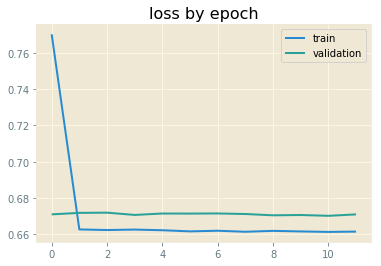

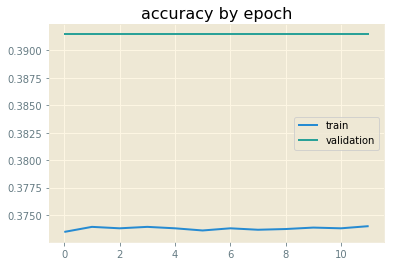

In [47]:
plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot(np.arange(len(validation_losses)), validation_losses, label='validation')
plt.legend()
plt.title("loss by epoch")
plt.show()

plt.plot(np.arange(len(train_accuracies)), train_accuracies, label='train')
plt.plot(np.arange(len(validation_accuracies)), validation_accuracies, label='validation')
plt.legend()
plt.title("accuracy by epoch")
plt.show()

In [48]:
train_rezult_metrics

([0.770180433410817,
  0.6627301558751334,
  0.6624000412942922,
  0.6626508851523562,
  0.6622872826084323,
  0.6616638499709493,
  0.6620057241326133,
  0.6614454264019419,
  0.6619437715889254,
  0.6616264662135013,
  0.661361804888707,
  0.6615384084256946],
 [0.6710197983856081,
  0.6718500892070566,
  0.6719619302719549,
  0.6707084682837646,
  0.6714872840075087,
  0.6714552298705284,
  0.6715250368750058,
  0.6712193188231074,
  0.6705043449386813,
  0.6706729380866331,
  0.6702224206097118,
  0.6710022358864264],
 [0.37346388907143324,
  0.37392390090030886,
  0.37379246894920154,
  0.37392390090030886,
  0.37379246894920154,
  0.37359532102254056,
  0.37379246894920154,
  0.3736610369980942,
  0.3737267529736479,
  0.3738581849247552,
  0.37379246894920154,
  0.3739896168758625],
 [0.3914629337539432,
  0.3914629337539432,
  0.3914629337539432,
  0.3914629337539432,
  0.3914629337539432,
  0.3914629337539432,
  0.3914629337539432,
  0.3914629337539432,
  0.3914629337539432,
 